In [ ]:
import pickle
import shapely
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt

# Add main repo to path
import sys
from os.path import expanduser
sys.path.append(expanduser('/Users/zachkeskinen/Documents/spicy-snow/'))

from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow

In [2]:
from shapely import geometry
from pathlib import Path
from itertools import product
for lon_min, lat_min in product(range(-117, -113), range(43, 46)):
    print(Path(f'~/scratch/spicy-lowman-quadrant/spicy-lowman_{lon_min}-{lon_min + 1}_{lat_min}-{lat_min + 1}.nc').expanduser())
    # area = geometry.box(-117, 43, -113, 46)

/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-117--116_43-44.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-117--116_44-45.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-117--116_45-46.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-116--115_43-44.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-116--115_44-45.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-116--115_45-46.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-115--114_43-44.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-115--114_44-45.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-115--114_45-46.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-114--113_43-44.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/spicy-lowman_-114--113_44-45.nc
/bsuhome/zacharykeskinen/scratch/spicy-lowm

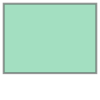

In [3]:
area

In [ ]:
ds = xr.open_dataset(Path('~/Desktop/spicy-lowman_-117--116_43-44.un.nc').expanduser())

In [ ]:
merged = merge_partial_s1_images(ds)